In [24]:
# work environment: jl2815
import pandas as pd
import numpy as np
import pickle
import os
import sys

from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormap module  # Create a colormap (e.g., 'viridis' or 'plasma')

from skgstat import Variogram
from scipy.spatial.distance import pdist, squareform

from typing import Callable   # nearest neighbor function input type
import sklearn.neighbors  # nearest neighbor
from sklearn.neighbors import BallTree # for space_center function
 
from GEMS_TCO import orbitmap
from GEMS_TCO.smoothspace import space_average

Testing

## Setup

Initiate ```gems_tco``` package, set coarse coordinates and then create a hash map ```coarse_dicts``` that maps timestamps to dataframe.

In [ ]:
output_dir = r"C:\\Users\\joonw\\TCO\\pipeline_2025\\outputs" # r raw string
os.makedirs(output_dir, exist_ok=True)                        # no error if directory already exist
os.chdir(output_dir)
print(os.getcwd())

df = pd.read_csv("C:\\Users\\joonw\\TCO\\data_engineering\\data_2024\\data_24_07_0131_N510_E110120.csv")
instance = orbitmap.MakeOrbitdata(df, 5,10,110,120)

# Load the dictionary from the pickle file
filepath = "C:\\Users\\joonw\\TCO\\data_engineering\\data_2024\\sparse_cen_map24_01.pkl"

with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y24m01day01_hm02:12']

rho_lat = 1
rho_lon = 1
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

print(len(lat_n))
print(len(lon_n))

100
200


Create the hash map ```coarse_dicts```, where the keys represent a combination of the year,month,day and hour and the values are filtered ```DataFrame```.

In [26]:
coarse_dicts = {}

years = ['2023','2024']
for year in years:
    for month in range(1, 13):  # Iterate over all months
        filepath = f"C:\\Users\\joonw\\TCO\\data_engineering\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)

        print(f"Finished processing {year} {month}.")

Finished processing 2023 1.
Finished processing 2023 2.
Finished processing 2023 3.
Finished processing 2023 4.
Finished processing 2023 5.
Finished processing 2023 6.
Finished processing 2023 7.
Finished processing 2023 8.
Finished processing 2023 9.
Finished processing 2023 10.
Finished processing 2023 11.
Finished processing 2023 12.
Finished processing 2024 1.
Finished processing 2024 2.
Finished processing 2024 3.
Finished processing 2024 4.
Finished processing 2024 5.
Finished processing 2024 6.
Finished processing 2024 7.
Finished processing 2024 8.
Finished processing 2024 9.
Finished processing 2024 10.
Finished processing 2024 11.
Finished processing 2024 12.


In [27]:
df_list = []

for key in coarse_dicts:
    df_list.append(coarse_dicts[key])

df_entire = pd.concat(df_list, axis=0, ignore_index=True)

We need to remove some outliers. 

In [28]:
print(df_entire.shape)
cur = df_entire.copy()
mask = (cur['ColumnAmountO3'] < 150) | (cur['ColumnAmountO3'] > 300)
cur = cur[~mask]
var_value = np.var(cur['ColumnAmountO3'])
cur.loc[mask, 'ColumnAmountO3'] = var_value

print(cur.shape)

(100780000, 5)
(100772645, 5)


In [29]:
coarse_dict = {}
for key in coarse_dicts:
    cur = coarse_dicts[key].copy()
    mask = (cur['ColumnAmountO3'] < 150) | (cur['ColumnAmountO3'] > 300)
    filtered_data = cur[~mask].reset_index(drop=True)

    # Handle cases where the filtered DataFrame is empty
    if filtered_data.empty:
        print(f"Warning: No valid data for key {key}. Skipping.")
        continue
    coarse_dict[key] = filtered_data

# Conclusion

## Timeseries plots var, variance, semivariograms.

We can clearly observe some short and long term cycles. Therefore, if I want to fit the data using deep learning models, we should consider ```LSTM``` rather than ```RNN``` to capture long term behaviors.

I considered using ```CNN``` to capture spatial dependence structure, followed by applying ```LSTM``` to capture temporal dependence structure. 

However, after extensive experiments, it seems ```CNN``` is not suited for capturing high resolution spatial information. Therefore, I suggest using ```Gaussian Process models``` to capture high resolution spatial information and then use ```LSTM``` to capture temporal information.

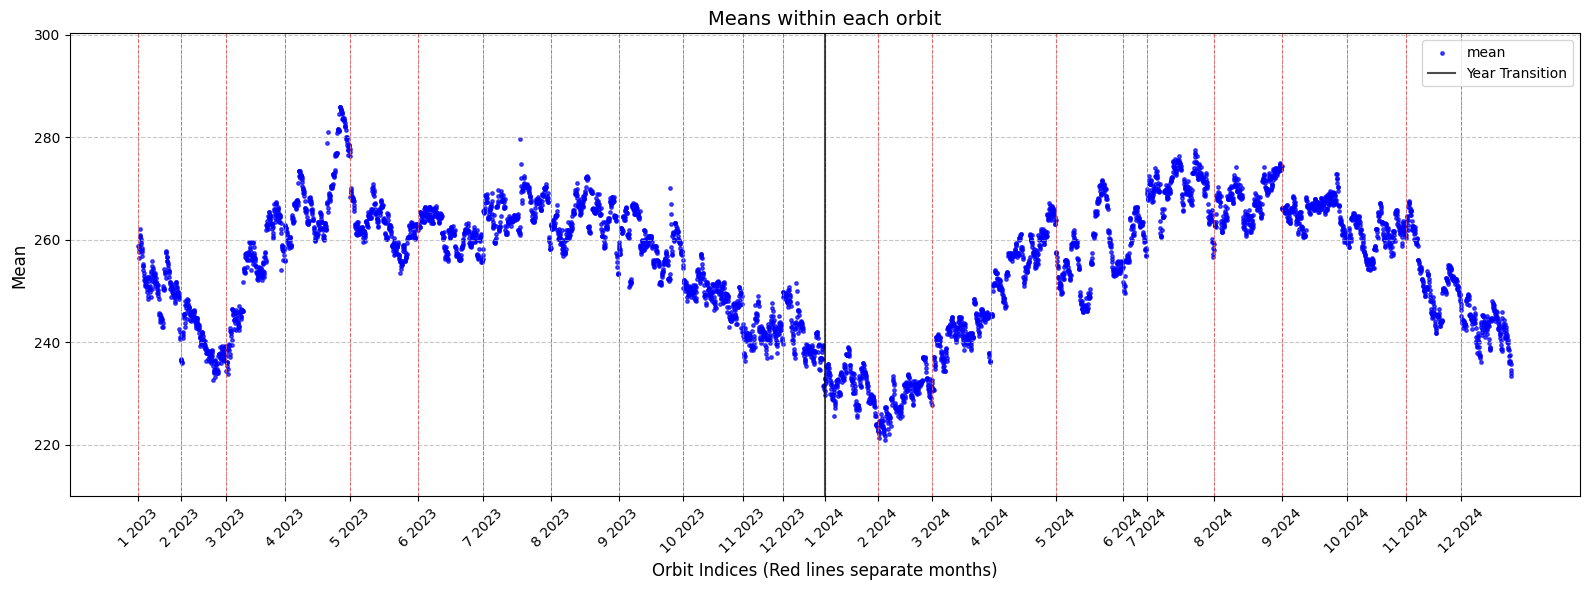

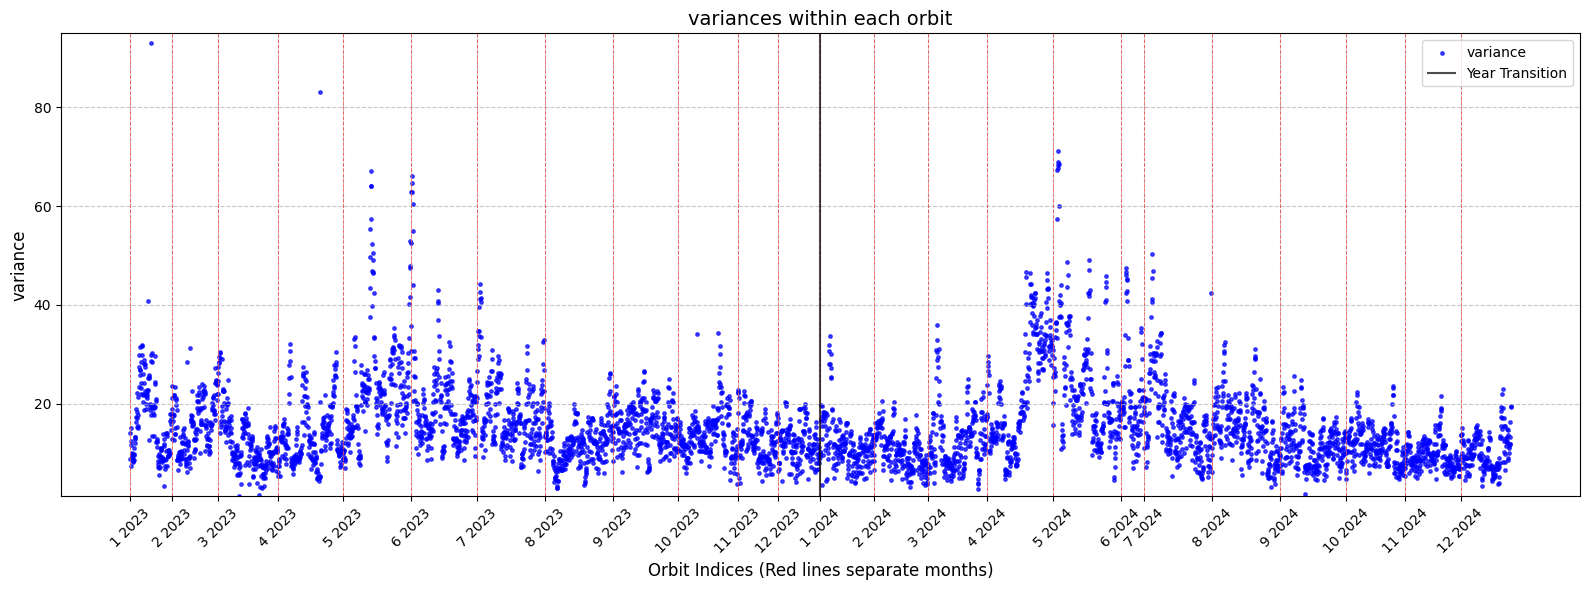

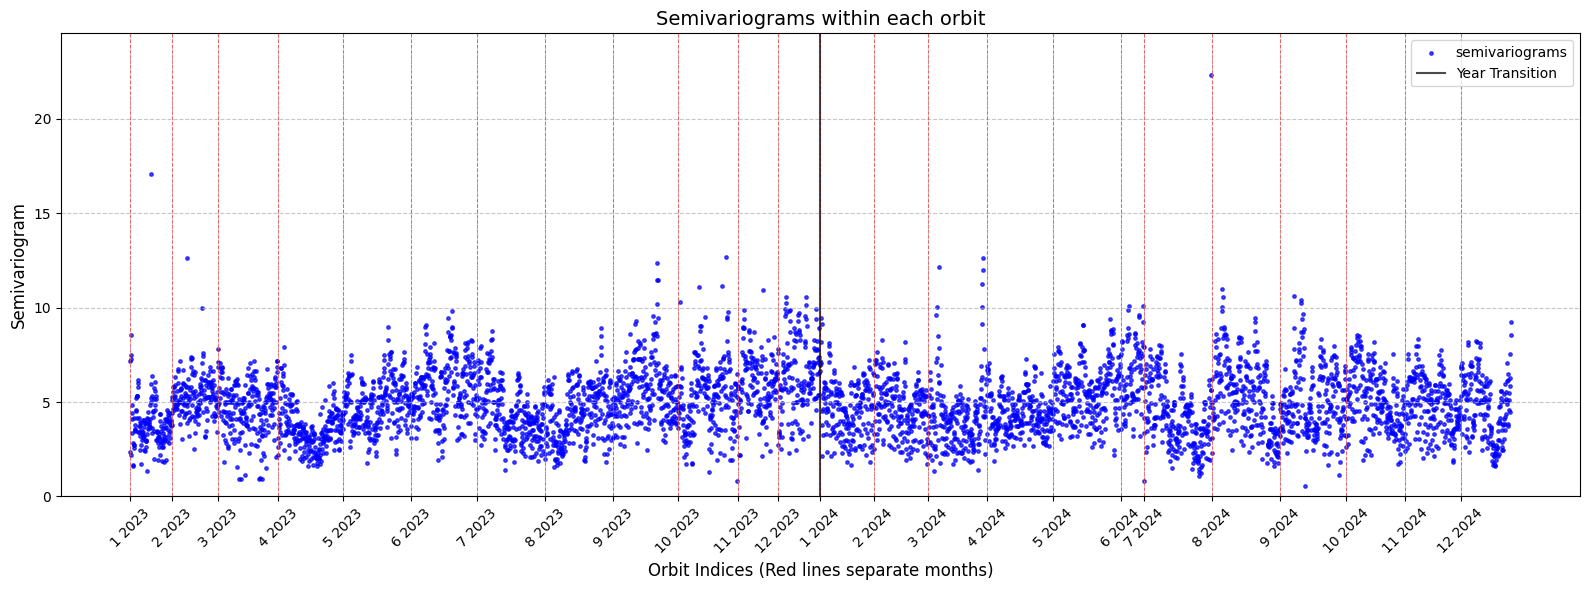

In [106]:
#### Mean Plot
plot_file = os.path.join(output_dir, f"Mean_plot.png")

plt.figure(figsize=(16, 6))
plt.scatter(normalized_orbit_indices, mean_timeseries, marker='o', s=6, color='b', alpha=0.7, label='Mean')

# Add month separation lines
for pos in normalized_month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

# Add year transition line
if year_transition is not None:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=normalized_month_positions, labels=month_labels, fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.title('Means within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([min(mean_timeseries) * 0.95, max(mean_timeseries) * 1.05])

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig(plot_file)
plt.show()

#### Variances Plot
plot_file = os.path.join(output_dir, f"Variance_plot.png")
plt.figure(figsize=(16, 6))
plt.scatter(normalized_orbit_indices, var_timeseries, marker='o', s=6, color='b', alpha=0.7, label='Variance')

# Add month separation lines
for pos in normalized_month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

# Add year transition line
if year_transition is not None:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=normalized_month_positions, labels=month_labels, fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.title('Variances within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([min(var_timeseries) * 0.97, max(var_timeseries) * 1.02])

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(plot_file)
plt.show()

##### semivariogram Plot
plot_file = os.path.join(output_dir, f"Semivariogram_plot.png")
plt.figure(figsize=(16, 6))
plt.scatter(normalized_orbit_indices, sem_timeseries, marker='o', s=6, color='b', alpha=0.7, label='Semivariograms')

# Add month separation lines
for pos in normalized_month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

# Add year transition line
if year_transition is not None:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=normalized_month_positions, labels=month_labels, fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('Semivariogram', fontsize=12)
plt.title('Semivariograms within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([0, max(filter(lambda x: not np.isnan(x), sem_timeseries)) * 1.1])

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(plot_file)
plt.show()

# Reference codes

Means

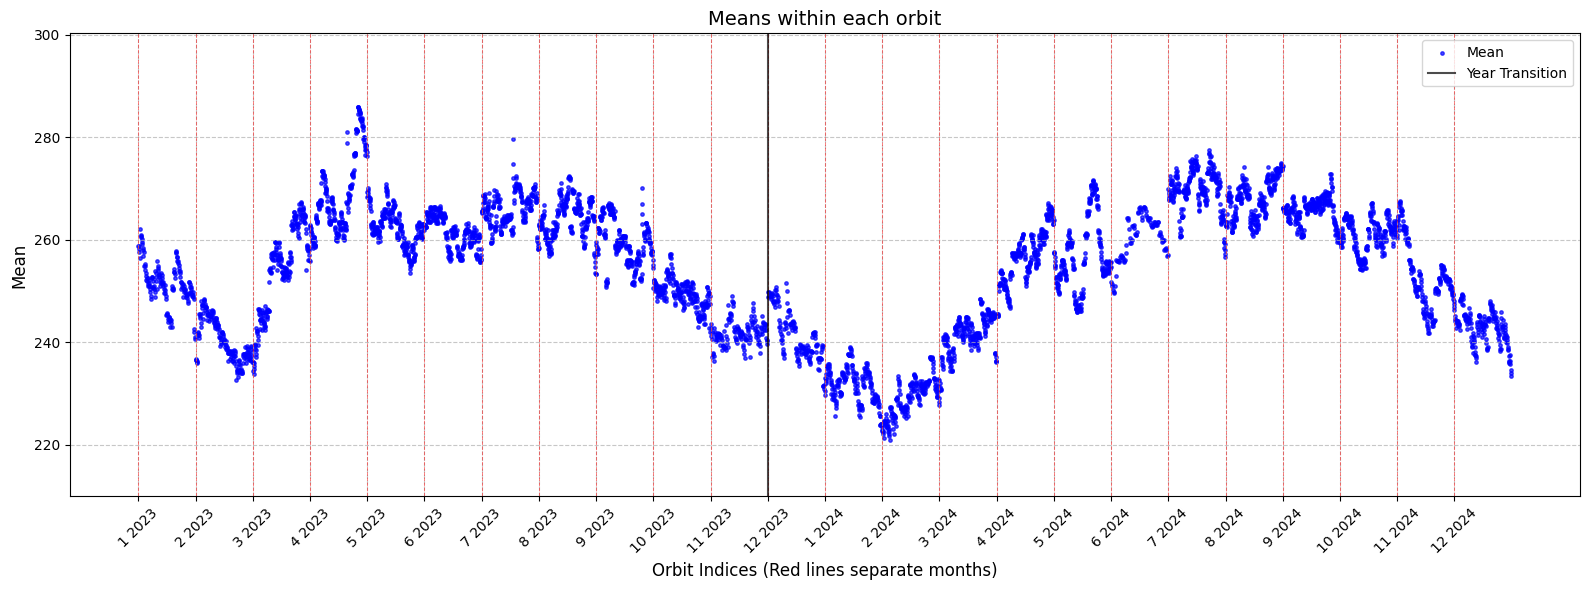

In [30]:
mean_timeseries = []
m_labels = ['1']
prev_month = '01'
year_transition = None

# Count the number of entries per month
month_lengths = []  # To store the number of data points per month
current_month_count = 0

# Calculate means and track month markers
for idx, key in enumerate(coarse_dict.keys()):
    cur = coarse_dict[key]
    mean_timeseries.append(np.mean(cur['ColumnAmountO3']))
    current_month = key[5:7]
    if current_month != prev_month:
        month_lengths.append(current_month_count)  # Store the count for the previous month
        current_month_count = 0  # Reset for the new month
        m_labels.append(f"{int(current_month)}")  # Add month label
        prev_month = current_month
    current_month_count += 1
    # Track year transition
    if key[:4] == '2024' and year_transition is None:
        year_transition = len(month_lengths)  # Track the month index for the year transition

# Append the count for the last month
month_lengths.append(current_month_count)

# Normalize x-axis for equal month widths
normalized_orbit_indices = []
for month_index, length in enumerate(month_lengths):
    normalized_orbit_indices.extend([month_index + 1 + (i / length) for i in range(length)])

# Create normalized month positions
normalized_month_positions = range(1, len(month_lengths) + 1)

# Plot
plt.figure(figsize=(16, 6))
plt.scatter(normalized_orbit_indices, mean_timeseries, marker='o', s=6, color='b', alpha=0.7, label='Mean')

# Add month separation lines
for pos in normalized_month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

# Add year transition line
if year_transition is not None:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=normalized_month_positions, labels=month_labels, fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.title('Means within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([min(mean_timeseries) * 0.95, max(mean_timeseries) * 1.05])

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

Variances

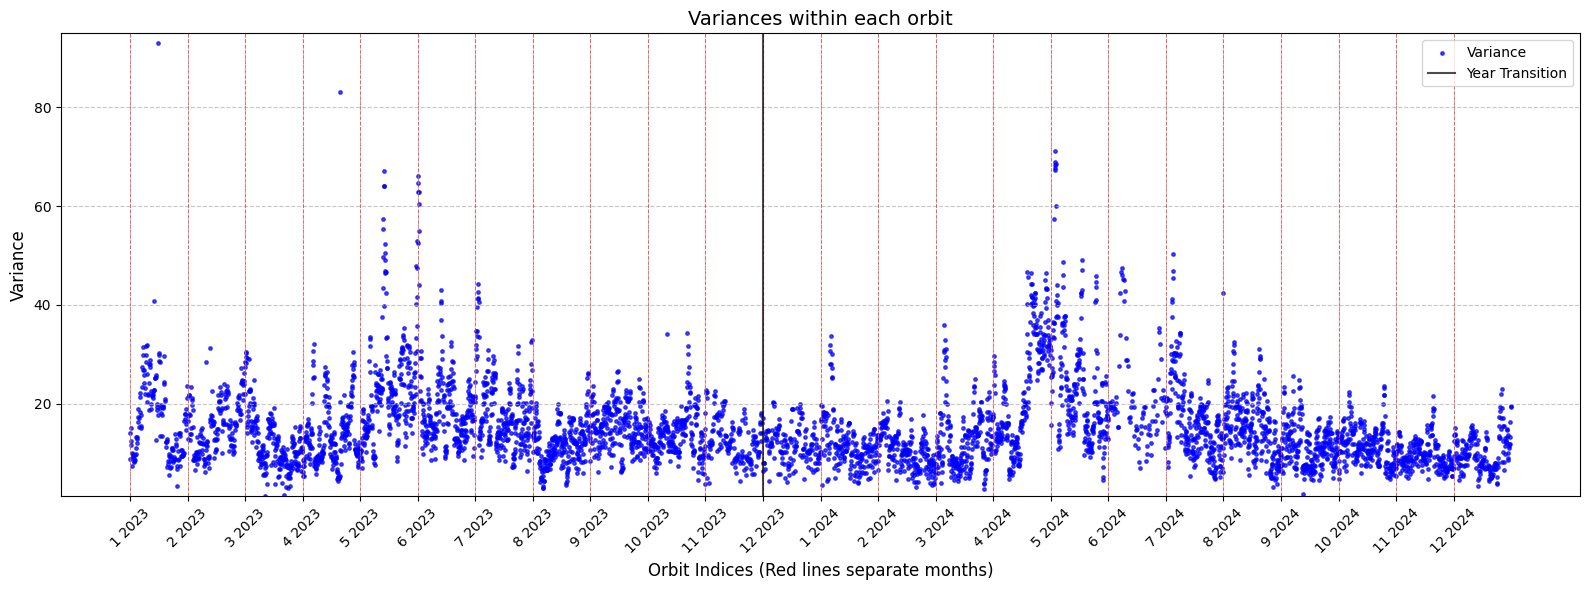

In [31]:
var_timeseries = []
m_labels = ['1']
prev_month = '01'
year_transition = None

# Count the number of entries per month
month_lengths = []  # To store the number of data points per month
current_month_count = 0

# Calculate variances and track month markers
for idx, key in enumerate(coarse_dict.keys()):
    cur = coarse_dict[key]
    # Compute variance for the current orbit
    var_timeseries.append(np.var(cur['ColumnAmountO3']))
    # Check for month changes
    current_month = key[5:7]
    if current_month != prev_month:
        month_lengths.append(current_month_count)  # Store the count for the previous month
        current_month_count = 0  # Reset for the new month
        m_labels.append(f"{int(current_month)}")  # Add month label
        prev_month = current_month
    current_month_count += 1
    # Track year transition
    if key[:4] == '2024' and year_transition is None:
        year_transition = len(month_lengths)  # Track the month index for year transition

# Append the count for the last month
month_lengths.append(current_month_count)

# Normalize x-axis for equal month widths
normalized_orbit_indices = []
for month_index, length in enumerate(month_lengths):
    normalized_orbit_indices.extend([month_index + 1 + (i / length) for i in range(length)])

# Create normalized month positions
normalized_month_positions = range(1, len(month_lengths) + 1)

# Plot
plt.figure(figsize=(16, 6))
plt.scatter(normalized_orbit_indices, var_timeseries, marker='o', s=6, color='b', alpha=0.7, label='Variance')

# Add month separation lines
for pos in normalized_month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

# Add year transition line
if year_transition is not None:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=normalized_month_positions, labels=month_labels, fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.title('Variances within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([min(var_timeseries) * 0.97, max(var_timeseries) * 1.02])

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Semivariograms

In [ ]:
sem_timeseries = []
m_labels = ['1']
prev_month = '01'
year_transition = None

sem_lag = 0.2
tolerance = 0.02

# Count the number of entries per month
month_lengths = []  # To store the number of data points per month
current_month_count = 0

# Calculate semivariograms and track month markers
for idx, key in enumerate(coarse_dict.keys()):
    cur = coarse_dict[key]
    coordinates = np.array(cur[['Latitude', 'Longitude']])
    values = np.array(cur['ColumnAmountO3'])
    pairwise_distances = squareform(pdist(coordinates))
    valid_pairs = np.where((pairwise_distances >= sem_lag - tolerance) &
                           (pairwise_distances <= sem_lag + tolerance))

    if len(valid_pairs[0]) == 0:
        sem_timeseries.append(np.nan)  # Append NaN for missing semivariances
    else:
        semivariances = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)
        sem_timeseries.append(semivariances)

    # Month markers
    current_month = key[5:7]
    if current_month != prev_month:
        month_lengths.append(current_month_count)  # Store the count for the previous month
        current_month_count = 0  # Reset for the new month
        m_labels.append(f"{int(current_month)}")  # Add month label
        prev_month = current_month
    current_month_count += 1
    # Track year transition
    if key[:4] == '2024' and year_transition is None:
        year_transition = len(month_lengths)  # Track the month index for year transition

# Append the count for the last month
month_lengths.append(current_month_count)

# Normalize x-axis for equal month widths
normalized_orbit_indices = []
for month_index, length in enumerate(month_lengths):
    normalized_orbit_indices.extend([month_index + 1 + (i / length) for i in range(length)])

# Create normalized month positions
normalized_month_positions = range(1, len(month_lengths) + 1)

# Plot
plt.figure(figsize=(16, 6))
plt.scatter(normalized_orbit_indices, sem_timeseries, marker='o', s=6, color='b', alpha=0.7, label='Semivariograms')

# Add month separation lines
for pos in normalized_month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

# Add year transition line
if year_transition is not None:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=normalized_month_positions, labels=month_labels, fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('Semivariogram', fontsize=12)
plt.title('Semivariograms within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([0, max(filter(lambda x: not np.isnan(x), sem_timeseries)) * 1.1])

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Semivariogram without normalizing x

In [ ]:
sem_timeseries = []
month_positions = [0]
m_labels = ['1']
prev_month = '01'
year_transition = None

sem_lag = 0.2
tolerance = 0.02

# Generate variance and month markers
for idx, key in enumerate(coarse_dict.keys()):
    cur = coarse_dict[key]
    coordinates = np.array(cur[['Latitude', 'Longitude']])
    values = np.array(cur['ColumnAmountO3'])
    pairwise_distances = squareform(pdist(coordinates))
    valid_pairs = np.where((pairwise_distances >= sem_lag - tolerance) &
                            (pairwise_distances <= sem_lag + tolerance))

    if len(valid_pairs[0]) == 0:
        sem_timeseries.append(np.nan)
        continue

    semivariances = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)

    sem_timeseries.append(semivariances)
    current_month = key[5:7]
    if current_month != prev_month:
        month_positions.append(idx)
        m_labels.append(f"{int(current_month)}")  # Month numbers
        prev_month = current_month
    if key[:4] == '2024' and year_transition is None:
        year_transition = idx  # Track year change

# Generate orbit indices
orbit_indices = range(len(sem_timeseries))

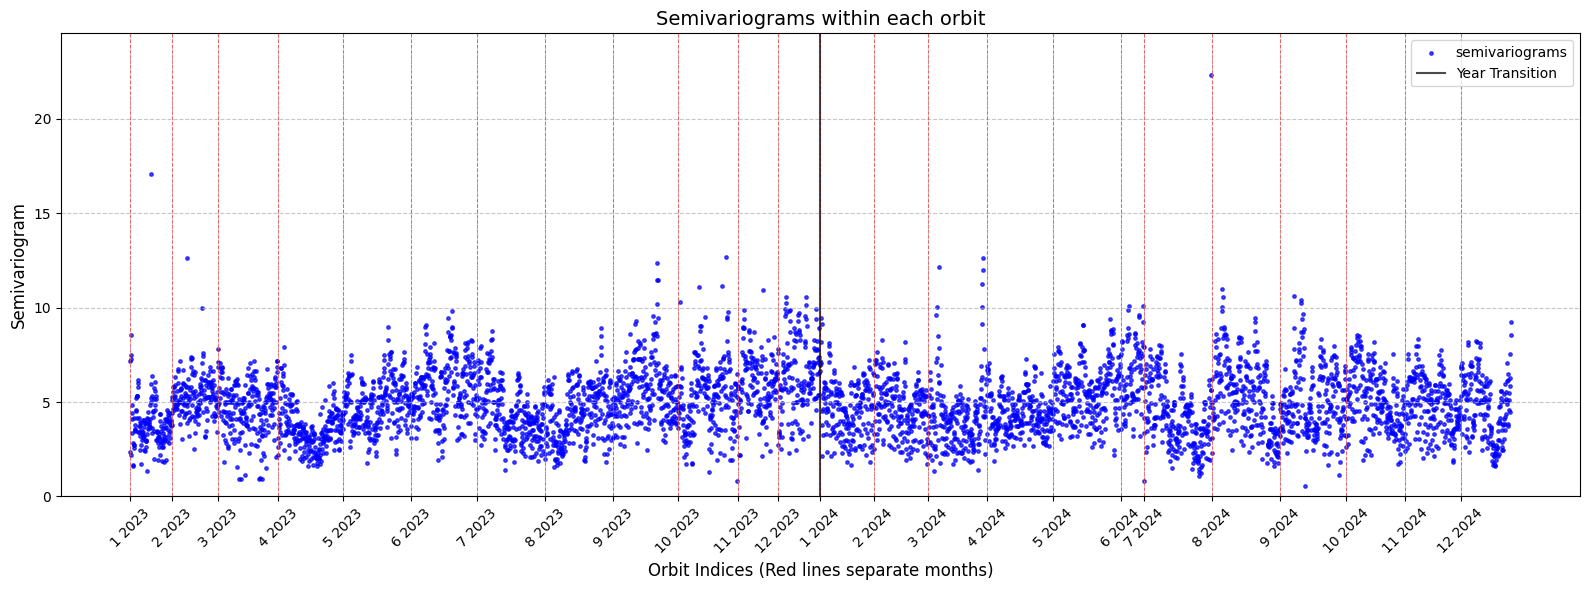

In [95]:
# Plot run 456 minute
plt.figure(figsize=(16, 6))
plt.scatter(orbit_indices, sem_timeseries, marker='o', s=6, color='b', alpha=0.7, label='semivariograms')

# Add month separation lines
for pos in month_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
# Add year transition line
if year_transition:
    plt.axvline(x=year_transition, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='Year Transition')

# Add X-ticks for months
month_labels = [f"{label} {'2023' if i < 12 else '2024'}" for i, label in enumerate(m_labels)]
plt.xticks(ticks=month_positions, labels=month_labels, fontsize=10, rotation=45)

# Highlight outliers
# outliers = [(i, val) for i, val in enumerate(var_timeseries) if val > 80]
# for idx, val in outliers:
#    plt.annotate(f"{val:.1f}", (idx, val), fontsize=8, color='red', ha='center')

# Labels and title
plt.xlabel('Orbit Indices (Red lines separate months)', fontsize=12)
plt.ylabel('Semivariogram', fontsize=12)
plt.title('Semivariograms within each orbit', fontsize=14)

# Adjust Y-axis dynamically
plt.ylim([0, max(sem_timeseries) * 1.1])

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()
